In [1]:
# common imports
import random
import numpy as np
import pandas as pd
import visualizations

Using TensorFlow backend.


### Data preparation

In [ ]:
train_data = pd.read_json('train/data/processed/train.json') 
test_data = pd.read_json('test/data/processed/test.json')

In [3]:
train_data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
band_1 = train_data['band_1'].as_matrix()
band_2 = train_data['band_2'].as_matrix()

In [5]:
X_con = np.array([np.concatenate((b1, b2)) for b1, b2 in zip(band_1, band_2)])
X_avg = np.array([(np.array(b1) + np.array(b2))/2 for b1, b2 in zip(band_1, band_2)])
y = train_data['is_iceberg'].as_matrix()

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X_avg = min_max_scaler.fit_transform(X_avg)
X_con = min_max_scaler.fit_transform(X_con)

In [7]:
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import log_loss, accuracy_score
scoring = {"log_loss": make_scorer(log_loss), "accuracy": make_scorer(accuracy_score)}

### Data Visualization

Is iceberg?  True


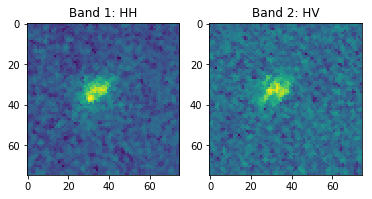

In [8]:
print("Is iceberg? ", True if train_data.iloc[5]['is_iceberg'] else False)
visualizations.show_bands(train_data.iloc[5])

Is iceberg?  False


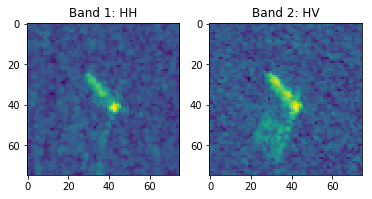

In [9]:
print("Is iceberg? ", True if train_data.iloc[42]['is_iceberg'] else False)
visualizations.show_bands(train_data.iloc[42])

### Benchmark Models

#### Random Guess

In [10]:
def random_guess_predictor(length):
    return [random.choice([0, 1]) for i in range(length)]

acc = []
loss = []
for i in range(22):
    predictions = np.array(random_guess_predictor(len(y)))
    acc.append(accuracy_score(y, predictions))
    loss.append(log_loss(y, predictions))

In [11]:
print ("Statistics for random guess:\n")
print ("Mean accuracy: {:,.4f}".format(np.mean(acc)))
print ("Mean loss: {:,.4f}".format(np.mean(loss)))

Statistics for random guess:

Mean accuracy: 0.5007
Mean loss: 17.2442


#### Logistic Regression

##### Logistic Regression with concatenated channels

In [12]:
# import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate

In [13]:
# train logistic regression model on the concatenated bands
model = LogisticRegression()
scores_con = cross_validate(model, X_con, y, cv = 5, scoring = scoring, return_train_score=False)

In [14]:
print ("Statistics for Logistic Regression (concatenated channels):\n")
print ("Mean fit time: {:,.2f}".format(scores_con['fit_time'].mean()))
print ("Mean score time: {:,.2f}".format(scores_con['score_time'].mean()))
print ("Mean test accuracy: {:,.2f}".format(scores_con['test_accuracy'].mean()))
print ("Mean test log_loss {:,.2f}".format(scores_con['test_log_loss'].mean()))

Statistics for Logistic Regression (concatenated channels):

Mean fit time: 2.70
Mean score time: 0.01
Mean test accuracy: 0.71
Mean test log_loss 10.06


##### Logistic regression with averaged channels

In [15]:
# train logistic regression model on the averaged bands
model = LogisticRegression()
scores_avg = cross_validate(model, X_avg, y, cv = 5, scoring = scoring, return_train_score=False)

In [16]:
print ("Statistics for Logistic Regression (averaged channels):\n")
print ("Mean fit time: {:,.2f}".format(scores_avg['fit_time'].mean()))
print ("Mean score time: {:,.2f}".format(scores_avg['score_time'].mean()))
print ("Mean test accuracy: {:,.2f}".format(scores_avg['test_accuracy'].mean()))
print ("Mean test log_loss {:,.2f}".format(scores_avg['test_log_loss'].mean()))

Statistics for Logistic Regression (averaged channels):

Mean fit time: 1.40
Mean score time: 0.00
Mean test accuracy: 0.67
Mean test log_loss 11.33


##### Logistic Regression with PCA

In [28]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

n_components = [200, 400, 600, 800]

pipe = Pipeline(steps=[('pca', PCA(whiten=True)), ('logictic', LogisticRegression())])
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logictic__C=[0.01, 0.1, 1, 10]), scoring = 'neg_log_loss', cv=3, verbose = 2, n_jobs=8)

estimator.fit(X_con, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] pca__n_components=200, logictic__C=0.01 .........................
[CV] pca__n_components=200, logictic__C=0.01 .........................
[CV] pca__n_components=200, logictic__C=0.01 .........................
[CV] pca__n_components=400, logictic__C=0.01 .........................
[CV] pca__n_components=400, logictic__C=0.01 .........................
[CV] pca__n_components=400, logictic__C=0.01 .........................
[CV] pca__n_components=600, logictic__C=0.01 .........................
[CV] pca__n_components=600, logictic__C=0.01 .........................
[CV] .......... pca__n_components=200, logictic__C=0.01, total=  16.5s
[CV] pca__n_components=600, logictic__C=0.01 .........................
[CV] .......... pca__n_components=200, logictic__C=0.01, total=  19.1s
[CV] pca__n_components=800, logictic__C=0.01 .........................
[CV] .......... pca__n_components=200, logictic__C=0.01, total=  30.3s
[CV] pca__n_comp

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.2min


[CV] ............. pca__n_components=400, logictic__C=1, total=  40.3s
[CV] pca__n_components=800, logictic__C=1 ............................
[CV] ............. pca__n_components=400, logictic__C=1, total=  42.3s
[CV] pca__n_components=800, logictic__C=1 ............................
[CV] ........... pca__n_components=800, logictic__C=0.1, total= 1.4min
[CV] pca__n_components=800, logictic__C=1 ............................
[CV] ............. pca__n_components=400, logictic__C=1, total=  44.5s
[CV] pca__n_components=200, logictic__C=10 ...........................
[CV] ........... pca__n_components=800, logictic__C=0.1, total= 1.5min
[CV] pca__n_components=200, logictic__C=10 ...........................
[CV] ............ pca__n_components=200, logictic__C=10, total=  24.0s
[CV] pca__n_components=200, logictic__C=10 ...........................
[CV] ............ pca__n_components=200, logictic__C=10, total=  24.0s
[CV] pca__n_components=400, logictic__C=10 ...........................
[CV] .

[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('logictic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'pca__n_components': [200, 400, 600, 800], 'logictic__C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

In [32]:
print("The best parameters are %s which give score %0.6f"
      % (estimator.best_params_, estimator.best_score_))

The best parameters are {'pca__n_components': 200, 'logictic__C': 0.1} which give score -0.514901


In [35]:
pipe = Pipeline(steps=[('pca', PCA(whiten=True, n_components = 200)), ('logictic', LogisticRegression(C = 0.1))])
scores = cross_validate(pipe, X_con, y, cv = 5, scoring = scoring, return_train_score=False)

In [36]:
print ("Statistics for Logistic Regression (with PCA):\n")
print ("Mean fit time: {:,.2f}".format(scores['fit_time'].mean()))
print ("Mean score time: {:,.2f}".format(scores['score_time'].mean()))
print ("Mean test accuracy: {:,.2f}".format(scores['test_accuracy'].mean()))
print ("Mean test log_loss {:,.2f}".format(scores['test_log_loss'].mean()))

Statistics for Logistic Regression (with PCA):

Mean fit time: 1.16
Mean score time: 0.05
Mean test accuracy: 0.73
Mean test log_loss 9.46


## Models

### Support Vector Machines (SVM)¶

#### Pure SVM

In [40]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
import scipy

In [43]:
param_grid = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=1.0/121),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid_svc = RandomizedSearchCV(svm.SVC(probability=True), param_distributions=param_grid, n_iter = 250, scoring = "neg_log_loss", cv=cv, verbose = 2, n_jobs=8)

grid_svc.fit(X_con, y)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV] C=7.41105169286, gamma=0.0011218483816, kernel=rbf, class_weight=None 
[CV] C=7.41105169286, gamma=0.0011218483816, kernel=rbf, class_weight=None 
[CV] C=7.41105169286, gamma=0.0011218483816, kernel=rbf, class_weight=None 
[CV] C=10.329854016, gamma=0.00843109001187, kernel=rbf, class_weight=balanced 
[CV] C=10.329854016, gamma=0.00843109001187, kernel=rbf, class_weight=balanced 
[CV] C=10.329854016, gamma=0.00843109001187, kernel=rbf, class_weight=balanced 
[CV] C=6.23792352845, gamma=0.00400090856866, kernel=rbf, class_weight=balanced 
[CV] C=6.23792352845, gamma=0.00400090856866, kernel=rbf, class_weight=balanced 
[CV]  C=7.41105169286, gamma=0.0011218483816, kernel=rbf, class_weight=None, total= 4.3min
[CV] C=6.23792352845, gamma=0.00400090856866, kernel=rbf, class_weight=balanced 
[CV]  C=7.41105169286, gamma=0.0011218483816, kernel=rbf, class_weight=None, total= 4.3min
[CV] C=11.2097327496, gamma=0.0116493326862,

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 21.0min


[CV]  C=0.770221072425, gamma=0.00776106252282, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=6.79653640923, gamma=0.0111832155149, kernel=rbf, class_weight=balanced 
[CV]  C=0.770221072425, gamma=0.00776106252282, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=6.79653640923, gamma=0.0111832155149, kernel=rbf, class_weight=balanced 
[CV]  C=0.14287497247, gamma=0.00100760157241, kernel=rbf, class_weight=balanced, total= 4.5min
[CV] C=6.79653640923, gamma=0.0111832155149, kernel=rbf, class_weight=balanced 
[CV]  C=0.14287497247, gamma=0.00100760157241, kernel=rbf, class_weight=balanced, total= 4.5min
[CV] C=3.22187075509, gamma=0.000615110718072, kernel=rbf, class_weight=balanced 
[CV]  C=0.242684680359, gamma=0.0148447459721, kernel=rbf, class_weight=None, total= 4.8min
[CV] C=3.22187075509, gamma=0.000615110718072, kernel=rbf, class_weight=balanced 
[CV]  C=0.242684680359, gamma=0.0148447459721, kernel=rbf, class_weight=None, total= 4.8min
[CV] C=3.22187075509, gamma=0.0006

[CV] C=0.41230375184, gamma=0.00605467993021, kernel=rbf, class_weight=None 
[CV]  C=4.75919198803, gamma=0.0327626975286, kernel=rbf, class_weight=balanced, total= 4.7min
[CV] C=36.717902953, gamma=0.00433103552417, kernel=rbf, class_weight=balanced 
[CV]  C=14.2612784846, gamma=0.00309550135033, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=36.717902953, gamma=0.00433103552417, kernel=rbf, class_weight=balanced 
[CV]  C=4.75919198803, gamma=0.0327626975286, kernel=rbf, class_weight=balanced, total= 4.7min
[CV] C=36.717902953, gamma=0.00433103552417, kernel=rbf, class_weight=balanced 
[CV]  C=14.2612784846, gamma=0.00309550135033, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=14.0234165815, gamma=0.00766225947672, kernel=rbf, class_weight=None 
[CV]  C=0.41230375184, gamma=0.00605467993021, kernel=rbf, class_weight=None, total= 4.1min
[CV] C=14.0234165815, gamma=0.00766225947672, kernel=rbf, class_weight=None 
[CV]  C=0.41230375184, gamma=0.00605467993021, kernel=rbf, clas

[CV]  C=24.4230939076, gamma=0.00386382129138, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=23.3210637239, gamma=0.00190190417538, kernel=rbf, class_weight=balanced 
[CV]  C=24.4230939076, gamma=0.00386382129138, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=12.8517494986, gamma=0.00317216770716, kernel=rbf, class_weight=None 
[CV]  C=24.4230939076, gamma=0.00386382129138, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=12.8517494986, gamma=0.00317216770716, kernel=rbf, class_weight=None 
[CV]  C=23.3210637239, gamma=0.00190190417538, kernel=rbf, class_weight=balanced, total= 4.5min
[CV] C=12.8517494986, gamma=0.00317216770716, kernel=rbf, class_weight=None 
[CV]  C=23.3210637239, gamma=0.00190190417538, kernel=rbf, class_weight=balanced, total= 4.5min
[CV] C=20.9545503316, gamma=0.00170083385658, kernel=rbf, class_weight=balanced 
[CV]  C=4.98077831887, gamma=0.016862891844, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=20.9545503316, gamma=0.00170083385658, ker

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 100.2min


[CV]  C=1.02694399635, gamma=0.0103841429797, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=6.11228402054, gamma=0.00761771622678, kernel=rbf, class_weight=balanced 
[CV]  C=2.9425646113, gamma=0.0138649223241, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=6.11228402054, gamma=0.00761771622678, kernel=rbf, class_weight=balanced 
[CV]  C=2.9425646113, gamma=0.0138649223241, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=7.33365699094, gamma=0.00079250366512, kernel=rbf, class_weight=None 
[CV]  C=27.9917079479, gamma=0.0239653706461, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=7.33365699094, gamma=0.00079250366512, kernel=rbf, class_weight=None 
[CV]  C=2.9425646113, gamma=0.0138649223241, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=7.33365699094, gamma=0.00079250366512, kernel=rbf, class_weight=None 
[CV]  C=27.9917079479, gamma=0.0239653706461, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=15.130639412, gamma=0.000541056588011, kernel=rbf, class_

[CV] C=24.6630193232, gamma=0.0177837892411, kernel=rbf, class_weight=None 
[CV]  C=36.6149082697, gamma=0.00589817749945, kernel=rbf, class_weight=balanced, total= 5.3min
[CV] C=24.6630193232, gamma=0.0177837892411, kernel=rbf, class_weight=None 
[CV]  C=10.7586020266, gamma=0.0210969746903, kernel=rbf, class_weight=balanced, total= 5.4min
[CV] C=24.6630193232, gamma=0.0177837892411, kernel=rbf, class_weight=None 
[CV]  C=10.7586020266, gamma=0.0210969746903, kernel=rbf, class_weight=balanced, total= 5.5min
[CV] C=6.35216314342, gamma=0.00354878560461, kernel=rbf, class_weight=balanced 
[CV]  C=3.47618357518, gamma=0.00736962778805, kernel=rbf, class_weight=balanced, total= 5.4min
[CV] C=6.35216314342, gamma=0.00354878560461, kernel=rbf, class_weight=balanced 
[CV]  C=10.7586020266, gamma=0.0210969746903, kernel=rbf, class_weight=balanced, total= 5.5min
[CV] C=6.35216314342, gamma=0.00354878560461, kernel=rbf, class_weight=balanced 
[CV]  C=3.47618357518, gamma=0.00736962778805, kerne

[CV] C=8.78276002924, gamma=0.0139567066688, kernel=rbf, class_weight=balanced 
[CV]  C=5.15774413054, gamma=0.00655595328334, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=8.78276002924, gamma=0.0139567066688, kernel=rbf, class_weight=balanced 
[CV]  C=14.7919401414, gamma=0.00811433034393, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=8.78276002924, gamma=0.0139567066688, kernel=rbf, class_weight=balanced 
[CV]  C=14.7919401414, gamma=0.00811433034393, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=5.12895304401, gamma=0.0290296109745, kernel=rbf, class_weight=None 
[CV]  C=14.7919401414, gamma=0.00811433034393, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=5.12895304401, gamma=0.0290296109745, kernel=rbf, class_weight=None 
[CV]  C=26.9334843828, gamma=0.0173644319911, kernel=rbf, class_weight=balanced, total= 4.7min
[CV] C=5.12895304401, gamma=0.0290296109745, kernel=rbf, class_weight=None 
[CV]  C=26.9334843828, gamma=0.0173644319911, kernel=rbf, class_weigh

[CV] C=1.04282772981, gamma=0.0114869851539, kernel=rbf, class_weight=balanced 
[CV]  C=14.480424111, gamma=0.00416755427609, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=1.04282772981, gamma=0.0114869851539, kernel=rbf, class_weight=balanced 
[CV]  C=30.9616281939, gamma=0.0337725793732, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=1.04282772981, gamma=0.0114869851539, kernel=rbf, class_weight=balanced 
[CV]  C=1.43744148191, gamma=0.000696062290795, kernel=rbf, class_weight=None, total= 4.0min
[CV] C=2.954636044, gamma=0.00650648418199, kernel=rbf, class_weight=None 
[CV]  C=1.43744148191, gamma=0.000696062290795, kernel=rbf, class_weight=None, total= 4.0min
[CV] C=2.954636044, gamma=0.00650648418199, kernel=rbf, class_weight=None 
[CV]  C=30.9616281939, gamma=0.0337725793732, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=2.954636044, gamma=0.00650648418199, kernel=rbf, class_weight=None 
[CV]  C=30.9616281939, gamma=0.0337725793732, kernel=rbf, class_weight=None,

[CV] C=8.12190901219, gamma=0.000771407862836, kernel=rbf, class_weight=None 
[CV]  C=5.39171229399, gamma=0.00491276841304, kernel=rbf, class_weight=None, total= 5.2min
[CV] C=8.12190901219, gamma=0.000771407862836, kernel=rbf, class_weight=None 
[CV]  C=19.3941818923, gamma=0.00719121945533, kernel=rbf, class_weight=balanced, total= 5.4min
[CV] C=8.12190901219, gamma=0.000771407862836, kernel=rbf, class_weight=None 
[CV]  C=5.39171229399, gamma=0.00491276841304, kernel=rbf, class_weight=None, total= 5.3min
[CV] C=3.52916185565, gamma=0.00336850844857, kernel=rbf, class_weight=balanced 
[CV]  C=5.39171229399, gamma=0.00491276841304, kernel=rbf, class_weight=None, total= 5.3min
[CV] C=3.52916185565, gamma=0.00336850844857, kernel=rbf, class_weight=balanced 
[CV]  C=2.0174974913, gamma=0.00392607047694, kernel=rbf, class_weight=None, total= 5.0min
[CV] C=3.52916185565, gamma=0.00336850844857, kernel=rbf, class_weight=balanced 
[CV]  C=2.0174974913, gamma=0.00392607047694, kernel=rbf, cl

[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 243.6min


[CV]  C=3.52916185565, gamma=0.00336850844857, kernel=rbf, class_weight=balanced, total= 5.4min
[CV] C=8.54638086424, gamma=0.0092399700662, kernel=rbf, class_weight=balanced 
[CV]  C=3.23992310873, gamma=0.00162455044345, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=8.54638086424, gamma=0.0092399700662, kernel=rbf, class_weight=balanced 
[CV]  C=3.52916185565, gamma=0.00336850844857, kernel=rbf, class_weight=balanced, total= 5.3min
[CV] C=8.54638086424, gamma=0.0092399700662, kernel=rbf, class_weight=balanced 
[CV]  C=3.23992310873, gamma=0.00162455044345, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=4.40078971217, gamma=0.0193681334003, kernel=rbf, class_weight=None 
[CV]  C=3.23992310873, gamma=0.00162455044345, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=4.40078971217, gamma=0.0193681334003, kernel=rbf, class_weight=None 
[CV]  C=14.0031933741, gamma=0.00336239672403, kernel=rbf, class_weight=balanced, total= 5.4min
[CV] C=4.40078971217, gamma=0.0193681334003,

[CV] C=18.4032938355, gamma=0.000269179078641, kernel=rbf, class_weight=balanced 
[CV]  C=6.83949973223, gamma=0.00566870582763, kernel=rbf, class_weight=None, total= 5.0min
[CV] C=11.8608028261, gamma=0.000864098574088, kernel=rbf, class_weight=balanced 
[CV]  C=0.266897654481, gamma=0.00853996810542, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=11.8608028261, gamma=0.000864098574088, kernel=rbf, class_weight=balanced 
[CV]  C=6.83949973223, gamma=0.00566870582763, kernel=rbf, class_weight=None, total= 5.0min
[CV] C=11.8608028261, gamma=0.000864098574088, kernel=rbf, class_weight=balanced 
[CV]  C=0.266897654481, gamma=0.00853996810542, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=6.81000247997, gamma=0.000654147239001, kernel=rbf, class_weight=None 
[CV]  C=0.266897654481, gamma=0.00853996810542, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=6.81000247997, gamma=0.000654147239001, kernel=rbf, class_weight=None 
[CV]  C=18.4032938355, gamma=0.000269179078641, kerne

[CV]  C=23.8682997693, gamma=0.000848613431693, kernel=rbf, class_weight=balanced, total= 5.2min
[CV] C=14.9901834353, gamma=0.00173049296371, kernel=rbf, class_weight=balanced 
[CV]  C=12.0075503635, gamma=0.0103396112915, kernel=rbf, class_weight=None, total= 5.5min
[CV] C=33.3151506107, gamma=0.0100652828491, kernel=rbf, class_weight=balanced 
[CV]  C=23.8682997693, gamma=0.000848613431693, kernel=rbf, class_weight=balanced, total= 5.2min
[CV] C=33.3151506107, gamma=0.0100652828491, kernel=rbf, class_weight=balanced 
[CV]  C=6.06947350467, gamma=0.00331387300805, kernel=rbf, class_weight=None, total= 5.4min
[CV] C=33.3151506107, gamma=0.0100652828491, kernel=rbf, class_weight=balanced 
[CV]  C=6.06947350467, gamma=0.00331387300805, kernel=rbf, class_weight=None, total= 5.3min
[CV] C=8.9647653028, gamma=0.00807635708148, kernel=rbf, class_weight=None 
[CV]  C=6.06947350467, gamma=0.00331387300805, kernel=rbf, class_weight=None, total= 5.3min
[CV] C=8.9647653028, gamma=0.0080763570814

[CV] C=7.53786759132, gamma=0.000791876549593, kernel=rbf, class_weight=None 
[CV]  C=3.25148119581, gamma=0.0179667510392, kernel=rbf, class_weight=None, total= 5.5min
[CV] C=7.53786759132, gamma=0.000791876549593, kernel=rbf, class_weight=None 
[CV]  C=2.45858003229, gamma=0.00254378527585, kernel=rbf, class_weight=balanced, total= 5.0min
[CV] C=1.21070738932, gamma=0.0411114326828, kernel=rbf, class_weight=None 
[CV]  C=2.45858003229, gamma=0.00254378527585, kernel=rbf, class_weight=balanced, total= 4.9min
[CV] C=1.21070738932, gamma=0.0411114326828, kernel=rbf, class_weight=None 
[CV]  C=7.92484844473, gamma=0.00496900837007, kernel=rbf, class_weight=balanced, total= 5.2min
[CV] C=1.21070738932, gamma=0.0411114326828, kernel=rbf, class_weight=None 
[CV]  C=7.92484844473, gamma=0.00496900837007, kernel=rbf, class_weight=balanced, total= 5.2min
[CV] C=0.492398570525, gamma=0.00239818540397, kernel=rbf, class_weight=balanced 
[CV]  C=7.53786759132, gamma=0.000791876549593, kernel=rbf,

[CV]  C=1.6975383101, gamma=0.0216423014983, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=15.5019797126, gamma=0.00707026233822, kernel=rbf, class_weight=None 
[CV]  C=26.3312723471, gamma=0.00158212734705, kernel=rbf, class_weight=balanced, total= 4.4min
[CV] C=15.5019797126, gamma=0.00707026233822, kernel=rbf, class_weight=None 
[CV]  C=26.3312723471, gamma=0.00158212734705, kernel=rbf, class_weight=balanced, total= 4.4min
[CV] C=28.7301439552, gamma=0.00491740658507, kernel=rbf, class_weight=balanced 
[CV]  C=26.3312723471, gamma=0.00158212734705, kernel=rbf, class_weight=balanced, total= 4.5min
[CV] C=28.7301439552, gamma=0.00491740658507, kernel=rbf, class_weight=balanced 
[CV]  C=1.91974604856, gamma=0.00400653236512, kernel=rbf, class_weight=None, total= 4.4min
[CV] C=28.7301439552, gamma=0.00491740658507, kernel=rbf, class_weight=balanced 
[CV]  C=1.91974604856, gamma=0.00400653236512, kernel=rbf, class_weight=None, total= 4.4min
[CV] C=6.53576984506, gamma=0.01339884737

[CV] C=2.31566532339, gamma=0.000639698511217, kernel=rbf, class_weight=None 
[CV]  C=0.0537139496206, gamma=0.00774682319778, kernel=rbf, class_weight=balanced, total= 4.6min
[CV] C=2.31566532339, gamma=0.000639698511217, kernel=rbf, class_weight=None 
[CV]  C=23.1429923618, gamma=0.0124730508195, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=2.31566532339, gamma=0.000639698511217, kernel=rbf, class_weight=None 
[CV]  C=23.1429923618, gamma=0.0124730508195, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=2.62857962073, gamma=0.0172032720165, kernel=rbf, class_weight=None 
[CV]  C=8.88277357481, gamma=0.0048425920628, kernel=rbf, class_weight=balanced, total= 4.6min
[CV] C=2.62857962073, gamma=0.0172032720165, kernel=rbf, class_weight=None 
[CV]  C=23.1429923618, gamma=0.0124730508195, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=2.62857962073, gamma=0.0172032720165, kernel=rbf, class_weight=None 
[CV]  C=8.88277357481, gamma=0.0048425920628, kernel=rbf, class_weight=b

[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 443.9min


[CV]  C=14.2593488663, gamma=0.000670412527282, kernel=rbf, class_weight=None, total= 4.4min
[CV] C=3.3836513999, gamma=0.00326177420816, kernel=rbf, class_weight=None 
[CV]  C=24.1872831542, gamma=0.00255346358656, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=3.3836513999, gamma=0.00326177420816, kernel=rbf, class_weight=None 
[CV]  C=24.1872831542, gamma=0.00255346358656, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=14.5518553844, gamma=0.0118910405877, kernel=rbf, class_weight=None 
[CV]  C=24.1872831542, gamma=0.00255346358656, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=14.5518553844, gamma=0.0118910405877, kernel=rbf, class_weight=None 
[CV]  C=17.4072987387, gamma=0.00604482001564, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=14.5518553844, gamma=0.0118910405877, kernel=rbf, class_weight=None 
[CV]  C=17.4072987387, gamma=0.00604482001564, kernel=rbf, class_weight=None, total= 4.5min
[CV] C=17.0605287239, gamma=0.00686106859818, kernel=rbf, class_wei

[CV] C=7.61301039549, gamma=0.00171626878407, kernel=rbf, class_weight=None 
[CV]  C=4.55500726177, gamma=0.0111562700571, kernel=rbf, class_weight=balanced, total= 4.7min
[CV] C=7.61301039549, gamma=0.00171626878407, kernel=rbf, class_weight=None 
[CV]  C=0.202520880473, gamma=0.00459661249163, kernel=rbf, class_weight=None, total= 4.1min
[CV] C=7.61301039549, gamma=0.00171626878407, kernel=rbf, class_weight=None 
[CV]  C=0.202520880473, gamma=0.00459661249163, kernel=rbf, class_weight=None, total= 4.1min
[CV] C=5.7565574246, gamma=0.00144757533076, kernel=rbf, class_weight=None 
[CV]  C=0.202520880473, gamma=0.00459661249163, kernel=rbf, class_weight=None, total= 4.2min
[CV] C=5.7565574246, gamma=0.00144757533076, kernel=rbf, class_weight=None 
[CV]  C=24.7517326657, gamma=0.00634339504625, kernel=rbf, class_weight=None, total= 4.6min
[CV] C=5.7565574246, gamma=0.00144757533076, kernel=rbf, class_weight=None 
[CV]  C=24.7517326657, gamma=0.00634339504625, kernel=rbf, class_weight=Non

[CV]  C=24.7352820007, gamma=0.000773395704999, kernel=rbf, class_weight=balanced, total= 4.4min
[CV] C=4.66311214463, gamma=0.00519962440568, kernel=rbf, class_weight=balanced 
[CV]  C=24.7352820007, gamma=0.000773395704999, kernel=rbf, class_weight=balanced, total= 4.4min
[CV] C=4.66311214463, gamma=0.00519962440568, kernel=rbf, class_weight=balanced 
[CV]  C=0.0998680864836, gamma=0.00254694115716, kernel=rbf, class_weight=balanced, total= 4.3min
[CV] C=4.66311214463, gamma=0.00519962440568, kernel=rbf, class_weight=balanced 
[CV]  C=0.0998680864836, gamma=0.00254694115716, kernel=rbf, class_weight=balanced, total= 4.3min
[CV] C=9.48834652139, gamma=0.0155971094224, kernel=rbf, class_weight=None 
[CV]  C=0.0998680864836, gamma=0.00254694115716, kernel=rbf, class_weight=balanced, total= 4.3min
[CV] C=9.48834652139, gamma=0.0155971094224, kernel=rbf, class_weight=None 
[CV]  C=10.8564727907, gamma=0.00981611747172, kernel=rbf, class_weight=None, total= 4.7min
[CV] C=9.48834652139, gam

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed: 521.0min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=250, n_jobs=8,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8787026128>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f87972455f8>, 'kernel': ['rbf'], 'class_weight': ['balanced', None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=2)

In [44]:
print("The best parameters are %s which give score %0.6f"
      % (grid_svc.best_params_, grid_svc.best_score_))

The best parameters are {'C': 11.152895753754946, 'gamma': 0.0051633968624387157, 'kernel': 'rbf', 'class_weight': None} which give score -0.441218


In [45]:
scores = cross_validate(svm.SVC(probability=True, C = 11.15, gamma = 0.005, kernel = 'rbf', class_weight = None), X_con, y, cv = 5, scoring = scoring, return_train_score=False)

In [47]:
print ("Statistics for SVM:\n")
print ("Mean fit time: {:,.2f}".format(scores['fit_time'].mean()))
print ("Mean score time: {:,.2f}".format(scores['score_time'].mean()))
print ("Mean test accuracy: {:,.2f}".format(scores['test_accuracy'].mean()))
print ("Mean test log_loss {:,.2f}".format(scores['test_log_loss'].mean()))

Statistics for SVM:

Mean fit time: 122.67
Mean score time: 11.48
Mean test accuracy: 0.80
Mean test log_loss 6.85


#### SVM with PCA

In [56]:
n_components = [400, 600, 800, 1000]
pipe = Pipeline(steps=[('pca', PCA(whiten=True)), ('svm', svm.SVC(probability=True))])

param_grid = dict(svm__C = scipy.stats.expon(scale=10), svm__gamma=scipy.stats.expon(scale=1.0/121),
          svm__kernel=['rbf'], pca__n_components=n_components)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
rand_svc = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter = 250, scoring = "neg_log_loss", cv=cv, verbose = 2, n_jobs=8)

rand_svc.fit(X_con, y)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV] pca__n_components=1000, svm__gamma=0.021169301333, svm__C=20.8930737192, svm__kernel=rbf 
[CV] pca__n_components=1000, svm__gamma=0.021169301333, svm__C=20.8930737192, svm__kernel=rbf 
[CV] pca__n_components=1000, svm__gamma=0.021169301333, svm__C=20.8930737192, svm__kernel=rbf 
[CV] pca__n_components=1000, svm__gamma=0.00341356359629, svm__C=11.1896214887, svm__kernel=rbf 
[CV] pca__n_components=1000, svm__gamma=0.00341356359629, svm__C=11.1896214887, svm__kernel=rbf 
[CV] pca__n_components=1000, svm__gamma=0.00341356359629, svm__C=11.1896214887, svm__kernel=rbf 
[CV] pca__n_components=600, svm__gamma=0.00990821451275, svm__C=2.89401448952, svm__kernel=rbf 
[CV] pca__n_components=600, svm__gamma=0.00990821451275, svm__C=2.89401448952, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00990821451275, svm__C=2.89401448952, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=600, svm__gamma=0.00990821451275, s

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  7.1min


[CV]  pca__n_components=600, svm__gamma=0.00935240315013, svm__C=38.2408296784, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=800, svm__gamma=0.00368713688027, svm__C=29.8675480444, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=4.91743249271e-05, svm__C=5.28505435931, svm__kernel=rbf, total= 1.1min
[CV] pca__n_components=800, svm__gamma=0.00368713688027, svm__C=29.8675480444, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=4.91743249271e-05, svm__C=5.28505435931, svm__kernel=rbf, total= 1.0min
[CV] pca__n_components=800, svm__gamma=0.00368713688027, svm__C=29.8675480444, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00935240315013, svm__C=38.2408296784, svm__kernel=rbf, total= 1.6min
[CV] pca__n_components=400, svm__gamma=0.0172430289854, svm__C=5.46819445267, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0187041963148, svm__C=13.0373436791, svm__kernel=rbf, total= 2.0min
[CV] pca__n_components=400, svm__gamma=0.0172430289854, svm__

[CV]  pca__n_components=400, svm__gamma=0.0106616463727, svm__C=0.966678321224, svm__kernel=rbf, total= 1.2min
[CV] pca__n_components=800, svm__gamma=0.0102285379955, svm__C=11.0853106191, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.000403668616191, svm__C=1.52954331259, svm__kernel=rbf, total= 1.4min
[CV] pca__n_components=800, svm__gamma=0.0102285379955, svm__C=11.0853106191, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.00871674262362, svm__C=5.71657446839, svm__kernel=rbf, total= 2.4min
[CV] pca__n_components=1000, svm__gamma=0.00793115037254, svm__C=3.79758888535, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.000403668616191, svm__C=1.52954331259, svm__kernel=rbf, total= 1.3min
[CV] pca__n_components=1000, svm__gamma=0.00793115037254, svm__C=3.79758888535, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.00871674262362, svm__C=5.71657446839, svm__kernel=rbf, total= 2.5min
[CV] pca__n_components=1000, svm__gamma=0.00793115037254,

[CV]  pca__n_components=600, svm__gamma=0.00188182166824, svm__C=4.60093441522, svm__kernel=rbf, total= 1.5min
[CV] pca__n_components=600, svm__gamma=0.0115629427675, svm__C=5.03050586169, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0101443903787, svm__C=1.7219386652, svm__kernel=rbf, total= 1.9min
[CV] pca__n_components=1000, svm__gamma=0.0127518692089, svm__C=11.9230414242, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00188182166824, svm__C=4.60093441522, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=1000, svm__gamma=0.0127518692089, svm__C=11.9230414242, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0115629427675, svm__C=5.03050586169, svm__kernel=rbf, total= 1.5min
[CV] pca__n_components=1000, svm__gamma=0.0127518692089, svm__C=11.9230414242, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00586361772363, svm__C=2.84381569677, svm__kernel=rbf, total= 1.9min
[CV] pca__n_components=400, svm__gamma=0.000694813820216, svm__C=

[CV]  pca__n_components=800, svm__gamma=0.00887368293023, svm__C=3.84923003853, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.0226931476588, svm__C=27.7541038097, svm__kernel=rbf 


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 36.3min


[CV]  pca__n_components=800, svm__gamma=0.00066479634508, svm__C=1.60865287826, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.0226931476588, svm__C=27.7541038097, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00887368293023, svm__C=3.84923003853, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.0226931476588, svm__C=27.7541038097, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00066479634508, svm__C=1.60865287826, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=800, svm__gamma=0.00520777407772, svm__C=6.6424231771, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00756611096266, svm__C=15.1500830818, svm__kernel=rbf, total=  54.3s
[CV] pca__n_components=800, svm__gamma=0.00520777407772, svm__C=6.6424231771, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00066479634508, svm__C=1.60865287826, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=800, svm__gamma=0.00520777407772, svm__C

[CV] pca__n_components=600, svm__gamma=0.00376242755713, svm__C=29.9366803798, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0103833078609, svm__C=5.1014102327, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=600, svm__gamma=0.00376242755713, svm__C=29.9366803798, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0103833078609, svm__C=5.1014102327, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=800, svm__gamma=0.000552879904956, svm__C=4.27551528794, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0103833078609, svm__C=5.1014102327, svm__kernel=rbf, total= 1.6min
[CV] pca__n_components=800, svm__gamma=0.000552879904956, svm__C=4.27551528794, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00376242755713, svm__C=29.9366803798, svm__kernel=rbf, total= 1.3min
[CV] pca__n_components=800, svm__gamma=0.000552879904956, svm__C=4.27551528794, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00476132371298, svm__C=4.58750512236,

[CV] pca__n_components=600, svm__gamma=0.00896271161322, svm__C=2.99793922898, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00537493105422, svm__C=4.55408080305, svm__kernel=rbf, total= 2.3min
[CV] pca__n_components=600, svm__gamma=0.00313313332661, svm__C=18.7957143271, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00564269040519, svm__C=1.96167221264, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=600, svm__gamma=0.00313313332661, svm__C=18.7957143271, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0040701967451, svm__C=1.25687630321, svm__kernel=rbf, total= 2.4min
[CV] pca__n_components=600, svm__gamma=0.00313313332661, svm__C=18.7957143271, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0040701967451, svm__C=1.25687630321, svm__kernel=rbf, total= 2.2min
[CV] pca__n_components=800, svm__gamma=0.00577614857822, svm__C=62.0632034714, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00896271161322, svm__C=2.99793922898

[CV] pca__n_components=400, svm__gamma=0.00842690933238, svm__C=1.28335759793, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.0215292431549, svm__C=30.1928679984, svm__kernel=rbf, total= 2.8min
[CV] pca__n_components=400, svm__gamma=0.00842690933238, svm__C=1.28335759793, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.000442411089968, svm__C=22.1455159873, svm__kernel=rbf, total= 2.7min
[CV] pca__n_components=400, svm__gamma=0.00842690933238, svm__C=1.28335759793, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00854064621234, svm__C=10.0296877589, svm__kernel=rbf, total= 2.0min
[CV] pca__n_components=800, svm__gamma=0.000350327563712, svm__C=3.82304255552, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.000442411089968, svm__C=22.1455159873, svm__kernel=rbf, total= 2.4min
[CV] pca__n_components=800, svm__gamma=0.000350327563712, svm__C=3.82304255552, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00854064621234, svm__C=10.02

[CV]  pca__n_components=800, svm__gamma=0.0113305434214, svm__C=3.91937771217, svm__kernel=rbf, total= 2.3min
[CV] pca__n_components=1000, svm__gamma=0.00230837649748, svm__C=9.34644977068, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0113305434214, svm__C=3.91937771217, svm__kernel=rbf, total= 2.1min
[CV] pca__n_components=1000, svm__gamma=0.00230837649748, svm__C=9.34644977068, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.000301240718374, svm__C=1.24436768866, svm__kernel=rbf, total= 2.5min
[CV] pca__n_components=800, svm__gamma=0.0148386763862, svm__C=15.8452287787, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00804771663323, svm__C=9.07609869614, svm__kernel=rbf, total= 1.0min
[CV] pca__n_components=800, svm__gamma=0.0148386763862, svm__C=15.8452287787, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00804771663323, svm__C=9.07609869614, svm__kernel=rbf, total= 1.1min
[CV] pca__n_components=800, svm__gamma=0.0148386763862, svm__

[CV] pca__n_components=800, svm__gamma=0.0233357525935, svm__C=0.648927718931, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00768672139999, svm__C=29.5281120215, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=800, svm__gamma=0.0233357525935, svm__C=0.648927718931, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00768672139999, svm__C=29.5281120215, svm__kernel=rbf, total= 1.7min
[CV] pca__n_components=600, svm__gamma=0.00618968017802, svm__C=11.9800073671, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.002830082087, svm__C=0.402939362782, svm__kernel=rbf, total= 1.0min
[CV] pca__n_components=600, svm__gamma=0.00618968017802, svm__C=11.9800073671, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00410738244791, svm__C=0.841637067631, svm__kernel=rbf, total=  59.6s
[CV] pca__n_components=600, svm__gamma=0.00618968017802, svm__C=11.9800073671, svm__kernel=rbf 


[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 87.4min


[CV]  pca__n_components=400, svm__gamma=0.00410738244791, svm__C=0.841637067631, svm__kernel=rbf, total= 1.0min
[CV]  pca__n_components=400, svm__gamma=0.00410738244791, svm__C=0.841637067631, svm__kernel=rbf, total= 1.0min
[CV] pca__n_components=400, svm__gamma=0.000713661079844, svm__C=46.1038364944, svm__kernel=rbf 
[CV] pca__n_components=400, svm__gamma=0.000713661079844, svm__C=46.1038364944, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.000713661079844, svm__C=46.1038364944, svm__kernel=rbf, total=  57.8s
[CV] pca__n_components=400, svm__gamma=0.000713661079844, svm__C=46.1038364944, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.000713661079844, svm__C=46.1038364944, svm__kernel=rbf, total=  58.4s
[CV] pca__n_components=1000, svm__gamma=0.000241596869102, svm__C=0.316483988997, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0233357525935, svm__C=0.648927718931, svm__kernel=rbf, total= 1.9min
[CV] pca__n_components=1000, svm__gamma=0.000241596

[CV]  pca__n_components=400, svm__gamma=0.0022002513503, svm__C=25.88702417, svm__kernel=rbf, total=  53.5s
[CV] pca__n_components=400, svm__gamma=0.00591030330808, svm__C=29.0853389543, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.00344372869331, svm__C=29.6624439465, svm__kernel=rbf, total= 2.2min
[CV] pca__n_components=400, svm__gamma=0.00591030330808, svm__C=29.0853389543, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.0022002513503, svm__C=25.88702417, svm__kernel=rbf, total= 1.1min
[CV] pca__n_components=600, svm__gamma=0.00343021366648, svm__C=5.77771986535, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.00344372869331, svm__C=29.6624439465, svm__kernel=rbf, total= 2.3min
[CV] pca__n_components=600, svm__gamma=0.00343021366648, svm__C=5.77771986535, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00591030330808, svm__C=29.0853389543, svm__kernel=rbf, total=  58.1s
[CV] pca__n_components=600, svm__gamma=0.00343021366648, svm__C=5

[CV] pca__n_components=400, svm__gamma=0.00137570031151, svm__C=0.0848778733159, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00240932160383, svm__C=1.76806871448, svm__kernel=rbf, total= 1.9min
[CV] pca__n_components=400, svm__gamma=0.00137570031151, svm__C=0.0848778733159, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00240932160383, svm__C=1.76806871448, svm__kernel=rbf, total= 1.9min
[CV] pca__n_components=400, svm__gamma=0.000288340094058, svm__C=3.60660630073, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00137570031151, svm__C=0.0848778733159, svm__kernel=rbf, total= 1.2min
[CV] pca__n_components=400, svm__gamma=0.000288340094058, svm__C=3.60660630073, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00137570031151, svm__C=0.0848778733159, svm__kernel=rbf, total= 1.2min
[CV] pca__n_components=400, svm__gamma=0.000288340094058, svm__C=3.60660630073, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00137570031151, svm__C=

[CV] pca__n_components=400, svm__gamma=0.00132764283255, svm__C=2.77127255526, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00132764283255, svm__C=2.77127255526, svm__kernel=rbf, total=  43.9s
[CV] pca__n_components=400, svm__gamma=0.00612251185623, svm__C=0.485081444518, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00132764283255, svm__C=2.77127255526, svm__kernel=rbf, total=  43.5s
[CV] pca__n_components=400, svm__gamma=0.00612251185623, svm__C=0.485081444518, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0029920334882, svm__C=4.78668684331, svm__kernel=rbf, total= 1.2min
[CV] pca__n_components=400, svm__gamma=0.00612251185623, svm__C=0.485081444518, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.00487899092641, svm__C=1.3354138088, svm__kernel=rbf, total= 2.2min
[CV] pca__n_components=800, svm__gamma=0.00603253671052, svm__C=13.2308240088, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0029920334882, svm__C=4.78668684

[CV] pca__n_components=1000, svm__gamma=0.0010337265574, svm__C=3.05004759462, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.0151012148412, svm__C=15.7077054261, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.0010337265574, svm__C=3.05004759462, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.0130840525336, svm__C=6.00265738492, svm__kernel=rbf, total= 2.7min
[CV] pca__n_components=1000, svm__gamma=0.0010337265574, svm__C=3.05004759462, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.0130840525336, svm__C=6.00265738492, svm__kernel=rbf, total= 2.7min
[CV] pca__n_components=400, svm__gamma=0.0221539430255, svm__C=0.971844265772, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0221572706426, svm__C=9.80169680559, svm__kernel=rbf, total= 1.9min
[CV] pca__n_components=400, svm__gamma=0.0221539430255, svm__C=0.971844265772, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0221572706426, svm__C=9.80169680559,

[CV] pca__n_components=600, svm__gamma=0.0105953506202, svm__C=7.15416582736, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00146559237407, svm__C=6.46759847538, svm__kernel=rbf, total=  47.2s
[CV] pca__n_components=600, svm__gamma=0.0105953506202, svm__C=7.15416582736, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0269831596179, svm__C=15.7091039343, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=800, svm__gamma=0.00531799103906, svm__C=14.16724902, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0269831596179, svm__C=15.7091039343, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=800, svm__gamma=0.00531799103906, svm__C=14.16724902, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00585855513864, svm__C=5.20660294406, svm__kernel=rbf, total= 1.2min
[CV] pca__n_components=800, svm__gamma=0.00531799103906, svm__C=14.16724902, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00585855513864, svm__C=5.20660294406, svm__k

[CV] pca__n_components=400, svm__gamma=0.00186183771404, svm__C=10.2790905552, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00898950746315, svm__C=9.47699573208, svm__kernel=rbf, total= 2.0min
[CV] pca__n_components=1000, svm__gamma=0.00293995599953, svm__C=20.4800148374, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.00898950746315, svm__C=9.47699573208, svm__kernel=rbf, total= 2.1min
[CV] pca__n_components=1000, svm__gamma=0.00293995599953, svm__C=20.4800148374, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00186183771404, svm__C=10.2790905552, svm__kernel=rbf, total= 1.1min
[CV] pca__n_components=1000, svm__gamma=0.00293995599953, svm__C=20.4800148374, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00186183771404, svm__C=10.2790905552, svm__kernel=rbf, total= 1.1min
[CV] pca__n_components=1000, svm__gamma=0.000681130161321, svm__C=5.99480579514, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00186183771404, svm__C=10.279

[CV]  pca__n_components=1000, svm__gamma=0.00109397572278, svm__C=1.11420048774, svm__kernel=rbf, total= 2.2min
[CV] pca__n_components=600, svm__gamma=0.00605484485628, svm__C=11.7518241999, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.0196905165876, svm__C=1.87772388619, svm__kernel=rbf, total= 2.2min
[CV] pca__n_components=600, svm__gamma=0.00605484485628, svm__C=11.7518241999, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.0196905165876, svm__C=1.87772388619, svm__kernel=rbf, total= 2.1min
[CV] pca__n_components=600, svm__gamma=0.00605484485628, svm__C=11.7518241999, svm__kernel=rbf 
[CV]  pca__n_components=1000, svm__gamma=0.0196905165876, svm__C=1.87772388619, svm__kernel=rbf, total= 2.0min


[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 151.0min


[CV] pca__n_components=800, svm__gamma=0.028463389768, svm__C=4.17306793469, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00183099804141, svm__C=10.130794463, svm__kernel=rbf, total= 1.3min
[CV] pca__n_components=800, svm__gamma=0.028463389768, svm__C=4.17306793469, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00183099804141, svm__C=10.130794463, svm__kernel=rbf, total= 1.3min
[CV] pca__n_components=800, svm__gamma=0.028463389768, svm__C=4.17306793469, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.00183099804141, svm__C=10.130794463, svm__kernel=rbf, total= 1.2min
[CV] pca__n_components=800, svm__gamma=0.000207391612756, svm__C=18.6707745421, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00605484485628, svm__C=11.7518241999, svm__kernel=rbf, total= 1.6min
[CV] pca__n_components=800, svm__gamma=0.000207391612756, svm__C=18.6707745421, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00605484485628, svm__C=11.7518241999, svm

[CV] pca__n_components=1000, svm__gamma=0.00595638770874, svm__C=4.0425977128, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00348202126762, svm__C=34.5702799014, svm__kernel=rbf, total= 1.6min
[CV] pca__n_components=1000, svm__gamma=0.00595638770874, svm__C=4.0425977128, svm__kernel=rbf 
[CV]  pca__n_components=600, svm__gamma=0.00348202126762, svm__C=34.5702799014, svm__kernel=rbf, total= 1.5min
[CV] pca__n_components=400, svm__gamma=0.0016364761741, svm__C=7.44556395691, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.000395854375379, svm__C=13.2267460773, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=400, svm__gamma=0.0016364761741, svm__C=7.44556395691, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.000736463249676, svm__C=8.26502318336, svm__kernel=rbf, total= 2.0min
[CV] pca__n_components=400, svm__gamma=0.0016364761741, svm__C=7.44556395691, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.000736463249676, svm__C=8.265023183

[CV] pca__n_components=400, svm__gamma=0.0199236361852, svm__C=12.8101267136, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0133598822016, svm__C=6.9931273971, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.00324836493286, svm__C=2.04568116879, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0028705278884, svm__C=25.7279454812, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.00324836493286, svm__C=2.04568116879, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0133598822016, svm__C=6.9931273971, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=1000, svm__gamma=0.00324836493286, svm__C=2.04568116879, svm__kernel=rbf 
[CV]  pca__n_components=800, svm__gamma=0.0028705278884, svm__C=25.7279454812, svm__kernel=rbf, total= 1.8min
[CV] pca__n_components=800, svm__gamma=0.0115260441601, svm__C=7.50101929446, svm__kernel=rbf 
[CV]  pca__n_components=400, svm__gamma=0.0199236361852, svm__C=12.8101267136, sv

[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed: 176.6min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=250, n_jobs=8,
          param_distributions={'pca__n_components': [400, 600, 800, 1000], 'svm__kernel': ['rbf'], 'svm__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f879aaa99b0>, 'svm__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f879aaa9e48>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', s

In [60]:
print("The best parameters are %s which give score %0.6f"
      % (rand_svc.best_params_, rand_svc.best_score_))

The best parameters are {'pca__n_components': 400, 'svm__gamma': 4.9174324927149918e-05, 'svm__C': 5.2850543593096555, 'svm__kernel': 'rbf'} which give score -0.568405


In [61]:
scores = cross_validate(rand_svc.best_estimator_, X_con, y, cv = 5, scoring = scoring, return_train_score=False)

In [62]:
print ("Statistics for SVM (with PCA):\n")
print ("Mean fit time: {:,.2f}".format(scores['fit_time'].mean()))
print ("Mean score time: {:,.2f}".format(scores['score_time'].mean()))
print ("Mean test accuracy: {:,.2f}".format(scores['test_accuracy'].mean()))
print ("Mean test log_loss {:,.2f}".format(scores['test_log_loss'].mean()))

Statistics for SVM (with PCA):

Mean fit time: 7.04
Mean score time: 0.63
Mean test accuracy: 0.61
Mean test log_loss 13.41


#### Fine-tuning of the best model (w\o PCA)

In [76]:
param_grid = {'C': np.linspace(10.5, 12.5, 20), 'gamma': np.linspace(0.0045, 0.0055, 20)}

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
rand_svc = RandomizedSearchCV(svm.SVC(probability=True, kernel = 'rbf', class_weight = None), param_distributions=param_grid, n_iter = 100, scoring = "neg_log_loss", cv=cv, verbose = 2, n_jobs=8)

rand_svc.fit(X_con, y)

#'C': 11.152895753754946, 'gamma': 0.005163396862438715

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=11.4473684211, gamma=0.00481578947368 .........................
[CV] C=11.4473684211, gamma=0.00481578947368 .........................
[CV] C=11.4473684211, gamma=0.00481578947368 .........................
[CV] C=12.5, gamma=0.00492105263158 ..................................
[CV] C=12.5, gamma=0.00492105263158 ..................................
[CV] C=12.5, gamma=0.00492105263158 ..................................
[CV] C=11.4473684211, gamma=0.00460526315789 .........................
[CV] C=11.4473684211, gamma=0.00460526315789 .........................
[CV] .......... C=11.4473684211, gamma=0.00481578947368, total= 4.1min
[CV] C=11.4473684211, gamma=0.00460526315789 .........................
[CV] .......... C=11.4473684211, gamma=0.00481578947368, total= 4.1min
[CV] C=10.5, gamma=0.00497368421053 ..................................
[CV] .......... C=11.4473684211, gamma=0.00481578947368, total= 4.1min
[CV] C=10.5, g

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 20.9min


[CV] .......... C=10.7105263158, gamma=0.00481578947368, total= 4.5min
[CV] C=11.9736842105, gamma=0.00492105263158 .........................
[CV] .......... C=10.6052631579, gamma=0.00481578947368, total= 4.5min
[CV] C=11.9736842105, gamma=0.00492105263158 .........................
[CV] .......... C=10.7105263158, gamma=0.00481578947368, total= 4.6min
[CV] C=11.9736842105, gamma=0.00492105263158 .........................
[CV] .......... C=10.6052631579, gamma=0.00481578947368, total= 4.5min
[CV] C=10.7105263158, gamma=0.00492105263158 .........................
[CV] .......... C=10.6052631579, gamma=0.00481578947368, total= 4.5min
[CV] C=10.7105263158, gamma=0.00492105263158 .........................
[CV] .......... C=10.9210526316, gamma=0.00528947368421, total= 4.5min
[CV] C=10.7105263158, gamma=0.00492105263158 .........................
[CV] .......... C=10.9210526316, gamma=0.00528947368421, total= 4.5min
[CV] C=11.1315789474, gamma=0.00507894736842 .........................
[CV] .

[CV] .......... C=10.9210526316, gamma=0.00497368421053, total= 4.7min
[CV] C=12.0789473684, gamma=0.00471052631579 .........................
[CV] .......... C=11.7631578947, gamma=0.00528947368421, total= 4.7min
[CV] C=12.0789473684, gamma=0.00471052631579 .........................
[CV] .......... C=11.7631578947, gamma=0.00528947368421, total= 4.7min
[CV] C=11.9736842105, gamma=0.00513157894737 .........................
[CV] .......... C=11.7631578947, gamma=0.00528947368421, total= 4.7min
[CV] C=11.9736842105, gamma=0.00513157894737 .........................
[CV] .......... C=10.6052631579, gamma=0.00539473684211, total= 4.7min
[CV] C=11.9736842105, gamma=0.00513157894737 .........................
[CV] .......... C=10.6052631579, gamma=0.00539473684211, total= 4.6min
[CV] C=11.5526315789, gamma=0.00476315789474 .........................
[CV] .......... C=10.6052631579, gamma=0.00539473684211, total= 4.5min
[CV] C=11.5526315789, gamma=0.00476315789474 .........................
[CV] .

[CV] .......... C=11.6578947368, gamma=0.00481578947368, total= 4.5min
[CV] C=11.2368421053, gamma=0.00492105263158 .........................
[CV] .......... C=11.6578947368, gamma=0.00481578947368, total= 4.5min
[CV] C=11.6578947368, gamma=0.00455263157895 .........................
[CV] .......... C=11.6578947368, gamma=0.00481578947368, total= 4.5min
[CV] C=11.6578947368, gamma=0.00455263157895 .........................
[CV] .......... C=12.1842105263, gamma=0.00486842105263, total= 4.5min
[CV] C=11.6578947368, gamma=0.00455263157895 .........................
[CV] .......... C=12.1842105263, gamma=0.00486842105263, total= 4.5min
[CV] C=10.7105263158, gamma=0.00539473684211 .........................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 101.5min


[CV] .......... C=12.1842105263, gamma=0.00486842105263, total= 4.5min
[CV] C=10.7105263158, gamma=0.00539473684211 .........................
[CV] .......... C=11.2368421053, gamma=0.00492105263158, total= 4.5min
[CV] C=10.7105263158, gamma=0.00539473684211 .........................
[CV] .......... C=11.2368421053, gamma=0.00492105263158, total= 4.5min
[CV] C=11.7631578947, gamma=0.00544736842105 .........................
[CV] .......... C=11.2368421053, gamma=0.00492105263158, total= 4.5min
[CV] C=11.7631578947, gamma=0.00544736842105 .........................
[CV] .......... C=11.6578947368, gamma=0.00455263157895, total= 4.5min
[CV] C=11.7631578947, gamma=0.00544736842105 .........................
[CV] .......... C=11.6578947368, gamma=0.00455263157895, total= 4.5min
[CV] C=11.8684210526, gamma=0.00502631578947 .........................
[CV] .......... C=11.6578947368, gamma=0.00455263157895, total= 4.5min
[CV] C=11.8684210526, gamma=0.00502631578947 .........................
[CV] .

[CV] .......... C=11.9736842105, gamma=0.00502631578947, total= 4.5min
[CV] C=12.3947368421, gamma=0.00486842105263 .........................
[CV] .......... C=11.9736842105, gamma=0.00502631578947, total= 4.6min
[CV] C=11.5526315789, gamma=0.0045 ...................................
[CV] .......... C=11.9736842105, gamma=0.00502631578947, total= 4.5min
[CV] C=11.5526315789, gamma=0.0045 ...................................
[CV] .......... C=11.7631578947, gamma=0.00534210526316, total= 4.6min
[CV] C=11.5526315789, gamma=0.0045 ...................................
[CV] .......... C=11.7631578947, gamma=0.00534210526316, total= 4.5min
[CV] C=12.0789473684, gamma=0.00507894736842 .........................
[CV] .......... C=12.3947368421, gamma=0.00486842105263, total= 4.5min
[CV] C=12.0789473684, gamma=0.00507894736842 .........................
[CV] .......... C=11.7631578947, gamma=0.00534210526316, total= 4.5min
[CV] C=12.0789473684, gamma=0.00507894736842 .........................
[CV] .

[CV] .......... C=11.7631578947, gamma=0.00539473684211, total= 4.5min
[CV] C=12.0789473684, gamma=0.00518421052632 .........................
[CV] .......... C=11.7631578947, gamma=0.00539473684211, total= 4.5min
[CV] C=12.0789473684, gamma=0.00518421052632 .........................
[CV] .......... C=11.3421052632, gamma=0.00518421052632, total= 4.5min
[CV] C=12.0789473684, gamma=0.00518421052632 .........................
[CV] .......... C=11.3421052632, gamma=0.00518421052632, total= 4.5min
[CV] C=11.8684210526, gamma=0.0045 ...................................
[CV] .......... C=11.3421052632, gamma=0.00518421052632, total= 4.5min
[CV] C=11.8684210526, gamma=0.0045 ...................................
[CV] .......... C=12.2894736842, gamma=0.00465789473684, total= 4.5min
[CV] C=11.8684210526, gamma=0.0045 ...................................
[CV] .......... C=12.2894736842, gamma=0.00465789473684, total= 4.5min
[CV] C=10.7105263158, gamma=0.00502631578947 .........................
[CV] .

[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed: 201.1min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=8,
          param_distributions={'C': array([ 10.5    ,  10.60526,  10.71053,  10.81579,  10.92105,  11.02632,
        11.13158,  11.23684,  11.34211,  11.44737,  11.55263,  11.65789,
        11.76316,  11.86842,  11.97368,  12.07895,  12.18421,  12.28947,
        12.39474,  12.5    ]), 'gamma': array([ 0.0045 ...508,
        0.00513,  0.00518,  0.00524,  0.00529,  0.00534,  0.00539,
        0.00545,  0.0055 ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verb

In [77]:
print("The best parameters are %s which give score %0.6f"
      % (rand_svc.best_params_, rand_svc.best_score_))

The best parameters are {'C': 11.342105263157894, 'gamma': 0.0051842105263157894} which give score -0.441185


In [78]:
scores = cross_validate(rand_svc.best_estimator_, X_con, y, cv = 5, scoring = scoring, return_train_score=False)

In [79]:
print ("Statistics for SVM (step 2):\n")
print ("Mean fit time: {:,.2f}".format(scores['fit_time'].mean()))
print ("Mean score time: {:,.2f}".format(scores['score_time'].mean()))
print ("Mean test accuracy: {:,.2f}".format(scores['test_accuracy'].mean()))
print ("Mean test log_loss {:,.2f}".format(scores['test_log_loss'].mean()))

Statistics for SVM (step 2):

Mean fit time: 115.74
Mean score time: 10.94
Mean test accuracy: 0.80
Mean test log_loss 6.85
